In [1]:
import cv2
import urllib,urllib.request,sys
import ssl

In [2]:
host = 'https://aip.baidubce.com/oauth/2.0/token?grant_type=client_credentials&client_id=NG6OzcYLGvcycE5AHFwY5crS&client_secret=CYUm75VRHkxbKgjP40hOdYNcg2ttWUsp'
request = urllib.request.Request(host)
request.add_header('Content-Type','application/json;charset=UTF-8')
response = urllib.request.urlopen(request)
content = response.read()
if(content):
    print(content)

b'{"refresh_token":"25.7336e65d46cb0e4a0e5b65fe782075d4.315360000.1877566833.282335-16667612","expires_in":2592000,"session_key":"9mzdA55+yrQ7oN1Hw05VrI4QNq3lPO+r7q1tCsWs2ht\\/LxxNG710e1Nadqw\\/N4W\\/QKWcFpeUsY0vjmDmCpopWRxlPlwHYg==","access_token":"24.84b66652c1c1319197e873ed7c16bbf5.2592000.1564798833.282335-16667612","scope":"public vis-ocr_ocr brain_ocr_scope brain_ocr_general brain_ocr_general_basic vis-ocr_business_license brain_ocr_webimage brain_all_scope brain_ocr_idcard brain_ocr_driving_license brain_ocr_vehicle_license vis-ocr_plate_number brain_solution brain_ocr_plate_number brain_ocr_accurate brain_ocr_accurate_basic brain_ocr_receipt brain_ocr_business_license brain_solution_iocr brain_ocr_handwriting brain_ocr_passport brain_ocr_vat_invoice brain_numbers brain_ocr_train_ticket brain_ocr_taxi_receipt vis-ocr_household_register vis-ocr_vis-classify_birth_certificate vis-ocr_\\u53f0\\u6e7e\\u901a\\u884c\\u8bc1 vis-ocr_\\u6e2f\\u6fb3\\u901a\\u884c\\u8bc1 vis-ocr_\\u673a\\u

In [3]:
from aip import AipOcr

""" 你的 APPID AK SK """
APP_ID = '1666761'
API_KEY = 'NG6OzcYLGvcycE5AHFwY5crS'
SECRET_KEY = 'CYUm75VRHkxbKgjP40hOdYNcg2ttWUsp'

client = AipOcr(APP_ID, API_KEY, SECRET_KEY)

In [4]:
"""读取图片"""
filePath = '../water/test.jpg'
def get_file_content(filePath):
    with open(filePath,'rb') as fp:
        return fp.read()

image = get_file_content(filePath)

In [5]:
"""调用通用文字识别，图片参数为本地图片"""
client.basicGeneral(image)

"""可选参数"""
options = {}
options["language_type"] = "CHN_ENG"


"""带参数调用"""
client.basicGeneral(image,options)

{'log_id': 3935808922351737412,
 'words_result_num': 2,
 'words_result': [{'words': '06-10-2019星期一11:34:55'}, {'words': '利津水文站水尺'}]}

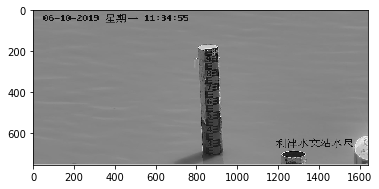

In [111]:
"""读取图片"""
from matplotlib import pyplot as plt
%matplotlib inline
img_path = '../water/test.jpg'
img = cv2.imread(img_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)
plt.imshow(gray)
plt.show()

In [7]:
"""去除文字噪声"""
def removeWord(gray):
    rows = gray.shape[0]
    cols = gray.shape[1]
    #print(rows,'\t',cols)
    #print(gray[5,10])
    for r in range(0,int(rows*0.1)):
        for c in range(0,int(cols*0.5)):
            gray[r,c] = 255
            
    for r in range(int(rows*0.75),rows):
        for c in range(int(cols*0.7),cols):
            gray[r,c] = 255

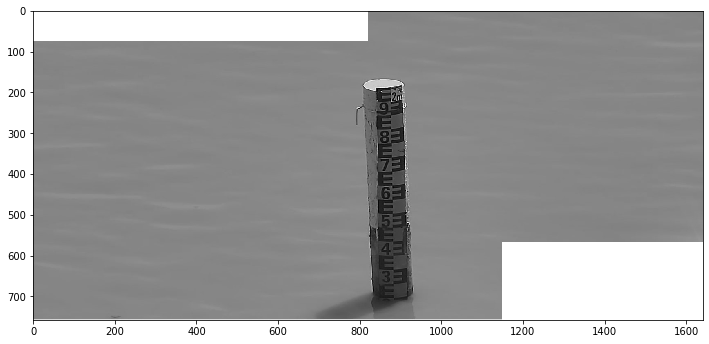

In [114]:
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)
removeWord(gray)
plt.imshow(gray)
plt.show()

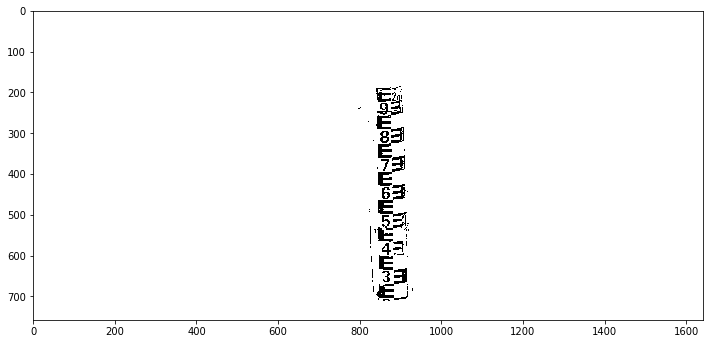

In [116]:
(ret,binary) = cv2.threshold(gray,38,255,cv2.THRESH_BINARY)
plt.imshow(binary)

In [99]:
"""凸显特征"""
def strength(binary):
    #闭运算降噪
    kernal = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2),(-1,-1))
    temp1 = cv2.morphologyEx(binary,cv2.MORPH_CLOSE,kernal)
    
    #凸显轮廓，便于分割
    kernal2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4),(-1,-1))
    temp2 = cv2.morphologyEx(temp1,cv2.MORPH_CLOSE,kernal2)
    
    #继续腐蚀膨胀
    temp3 = cv2.erode(temp2,kernal,4)
    temp4 = cv2.dilate(temp3,kernal,4)
    
    return temp4

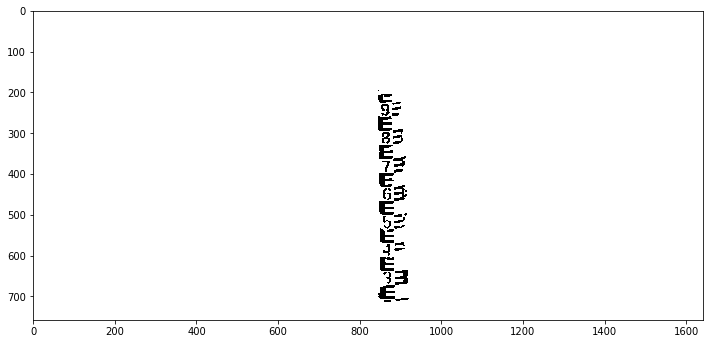

In [117]:
plt.rcParams['figure.figsize'] = [12, 8]
toCut = strength(binary.copy())
plt.imshow(toCut)

In [123]:
def cutROI(img):
    rows = img.shape[0]
    cols = img.shape[1]
    #print(rows,cols)
    
    #寻找top_y
    flag = False
    for r in range(0,rows):
        for c in range(0,cols):
            if img[r,c][0]==0:
                y1 = r
                #print(y1,'\t',c)
                flag = True
                break
        if flag == True:
            break

    #寻找down_y
    flag = False
    for r in range(rows-1,y1,-1):
        for c in range(0,cols):
            if img[r,c][0]==0:
                y2 = r
                #print(y2,'\t',c)
                flag = True
                break
        if flag == True:
            break
    
    #寻找left_x
    flag = False
    for c in range(0,cols):
        for r in range(0,rows):
            if img[r,c][0]==0:
                x1 = c
                #print(r,'\t',x1)
                flag = True
                break
        if flag == True:
            break
    
    #寻找right_x
    flag = False
    for c in range(cols-1,x1,-1):
        for r in range(0,rows):
            if img[r,c][0]==0:
                x2 = c
                #print(r,'\t',x2)
                flag = True
                break
        if flag == True:
            break
    
    #在原图中标记出
    imgcopy = cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),2)
    plt.imshow(imgcopy)
    plt.show()

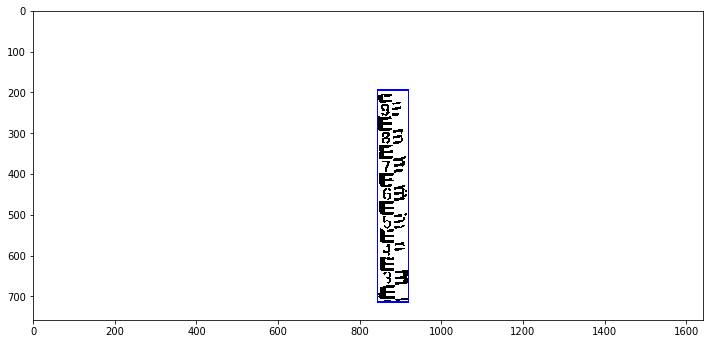

In [124]:
cutROI(toCut)